# Assembly of the Biot equations

In this tutorial we demonstrate how to assemble and solve the multi-physics Biot problem in PorePy. <br>
We consider the following discretization schemes:
* two-point flux approximation
* multi-point flux approximation
* dual virtual element method

**Note**: This tutorial will focus on a 2d domain, however most of the code works for 1d, 2d, and 3d domains.<br>

Let is $\Omega$ a regular domain with boundary $\partial \Omega$. The boundary can be divided in two non-overlapping parts useful to impose Dirichlet ($\partial \Omega_d$) and Neumann ($\partial \Omega_n$) boundary conditions. We indicate with $\mathbf{n}$ the outward unit normal vector of $\partial \Omega$.<br>
The Biot equations in primal formulation read:
$$ \nabla \cdot \frac{1}{2}D(\nabla \mathbf{u} + \nabla \mathbf{u}^T) + \alpha \nabla p = F \\
\frac{\partial}{\partial t}(\beta p + \alpha \nabla \cdot \mathbf{u}) + \nabla \cdot (\rho \mathbf{g} - K \nabla p) = f$$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad \quad \qquad - K \nabla p \cdot \mathbf{n} = v_b$$
$$ \mathbf{u} = \mathbf{u}_b \qquad \frac{1}{2}D(\nabla \mathbf{u} + \nabla \mathbf{u}^T) \cdot \mathbf{n} = t_b$$

In the above, the unknowns are the displacements $\mathbf{u}$ and the pressure $p$. The parameters are the scalar and vector source/sink terms $F$ and $f$, the permeability matrix $K$, the stiffness matrix $D$, the Biot coefficient $\alpha$, the fluid compressibility and density $\beta$ and $\rho$ and the gravity vector $\mathbf{g}$. $p_b$ is the pressure at the boundary (Dirichlet condition), $v_p$ is the flux at the boundary (Neumann condition), $\mathbf{u}_b$ is the displacement at the boundary (Dirichlet condition) and $t_b$ is the traction at the boundary (Neumann condition).<br>

We present *step-by-step* how to create the grid, declare the problem data, assemble the system of equations and finally solve the problem.

In [1]:
import numpy as np
import scipy.sparse as sps

import porepy as pp

In [2]:
def make_grid():
    # Define a grid for a toy problem
    gb = pp.meshing.cart_grid([], [2, 3])
    gb.compute_geometry()
    gb.assign_node_ordering()
    return gb


In [3]:
def assign_data(g, d, parameter_keyword_flow, parameter_keyword_mechanics):
    # Method to assign data.

    # We will mainly use default values for parameters, while overriding some of the 
    # values. 

    # Assign a non-default permeability, for illustrative purposes
    k = 2 * np.ones(g.num_cells)
    perm = pp.SecondOrderTensor(gb.dim_max(), k)

    bound_faces = g.get_all_boundary_faces()
    bound_flow = pp.BoundaryCondition(
        g, bound_faces.ravel("F"), ["dir"] * bound_faces.size
    )
    bound_mech = pp.BoundaryConditionVectorial(
        g, bound_faces.ravel("F"), ["dir"] * bound_faces.size
    )
    boundary_values_flow = np.zeros(g.num_faces)
    boundary_values_flow[0] = 1
    # Create a dictionary to override the default parameters
    specified_parameters_flow = {"second_order_tensor": perm, "biot_alpha": 1,
                                 "bc": bound_flow, "bc_values": boundary_values_flow}
    specified_parameters_mechanics = {"biot_alpha": 1, "bc": bound_mech}

    # Initialize the parameters for flow and transport.
    # The following keywords are used to define which set of default parameters to pick, i.e. the
    # type of parameters. For example, initialize_default_data initializes a second order permeability
    # tensor in the flow data, and a fourth order stiffness tensor in the mechanics data.
    parameter_type_flow = "flow"
    parameter_type_mechanics = "mechanics"
    pp.initialize_default_data(g, d, parameter_type_flow, specified_parameters_flow,
                               parameter_keyword_flow)
    pp.initialize_default_data(g, d, parameter_type_mechanics, specified_parameters_mechanics,
                               parameter_keyword_mechanics)


In [4]:
# The practical way of setting up a problem on a single grid
# with two variables and multiple terms is described here.

# Define a grid
gb = make_grid()
g = gb.grids_of_dimension(2)[0]
d = gb.node_props(g)
# Assign data, tagging them with the following keywords
kw_f = "flow"
kw_m = "mechanics"
assign_data(g, d, kw_f, kw_m)

# Discretize the mechanics related terms using the Biot class. This is a
# dirty trick to ensure efficient discretization where we re-use the 
# local gradient systems of MPSA (see pp/numerics/fv/mpsa.py) for all
# the mechanical terms involved.
biot_discretizer = pp.Biot()
biot_discretizer._discretize_mech(g, d)

# Variable names
v_0 = "displacement"
v_1 = "pressure"
# Names of the five terms of the equation + additional stabilization term.
# Note that the numbering (i and j in "term_ij") corresponds to the Biot
# equation as defined above, since stress equals stiffness tensor times the 
# symmetric gradient of displacement.
term_00 = "stress_divergence"          # div symmetric grad u
term_01 = "pressure_gradient"          # alpha grad p
term_10 = "displacement_divergence"    # d/dt alpha div u
term_11_0 = "fluid_mass"               # d/dt beta p
term_11_1 = "fluid_flux"               # div (rho g - K grad p)
term_11_2 = "stabilization"            #

# Store in the data dictionary d
d[pp.PRIMARY_VARIABLES] = {v_0: {"cells": g.dim}, v_1: {"cells": 1}}
d[pp.DISCRETIZATION] = {
    v_0: {term_00: pp.Mpsa(kw_m)},
    v_1: {
        term_11_0: pp.MassMatrix(kw_f),
        term_11_1: pp.Mpfa(kw_f),
        term_11_2: pp.BiotStabilization(kw_f),
    },
    v_0 + "_" + v_1: {term_01: pp.GradP(kw_m)},
    v_1 + "_" + v_0: {term_10: pp.DivD(kw_m)},
}



# The task of assembling the linear system is left to a dedicated object:
assembler = pp.Assembler()

# Assembly of the global linear system can in many cases be carried out by a
# single function call of the assembler. Note that for the current problem, 
# this is not possible. Rather, we had to discretize first by calling
# biot_discretizer._discretize_mech(g, d)

# Assemble the linear system, using the information stored in the GridBucket
A, b, block_dof, full_dof = assembler.assemble_matrix_rhs(gb)

# Here, A is the global linear system, and b is the corresponding right hand side.
# We can thus obtain the displacement and pressure solution by
x = sps.linalg.spsolve(A, b)

# The ordering of the unknowns in the global linear system will vary depending 
# on how the components in the GridBucket are traversed.
# Untangling the ordering is a two-stage process:
# 1. The system is ordered as a block system, with one block per combination of 
# primary variable and grid or edge (between grids). This information is stored
# in the field block_dof.
# 2. For each block, the local degrees of freedom can be obtained from the field
# full_dof

# To get the block number of a specific primary variable, we need the identifier
# of the relevant component in the GridBucket (either the grid, or the edge between
# grids), and the variable name.
# Getting the grids is easy, there is only one, namely g. Now, the block ordering 
# is obtained for the two variables 
block_v0 = block_dof[(g, v_0)]
block_v1 = block_dof[(g, v_1)]

# full_dof contains the number of dofs per block. To get a global ordering, use
global_dof = np.r_[0, np.cumsum(full_dof)]

# Get the global displacement and pressure dofs
global_displacement_dof = np.arange(global_dof[block_v0], global_dof[block_v0+1])
global_pressure_dof = np.arange(global_dof[block_v1], global_dof[block_v1+1])
# Print the pressure part of the system matrix
print(A.toarray()[global_pressure_dof, :][:, global_pressure_dof])

number of ncasym eliminated:  0
max igrad:  2.0
[[ 6.08437500e+01 -9.92708333e+00 -9.92708333e+00  1.04166667e-02
   0.00000000e+00  0.00000000e+00]
 [-9.92708333e+00  6.08437500e+01  1.04166667e-02 -9.92708333e+00
   0.00000000e+00  0.00000000e+00]
 [-9.92708333e+00  1.04166667e-02  5.07708333e+01 -9.93750000e+00
  -9.92708333e+00  1.04166667e-02]
 [ 1.04166667e-02 -9.92708333e+00 -9.93750000e+00  5.07708333e+01
   1.04166667e-02 -9.92708333e+00]
 [ 0.00000000e+00  0.00000000e+00 -9.92708333e+00  1.04166667e-02
   6.08437500e+01 -9.92708333e+00]
 [ 0.00000000e+00  0.00000000e+00  1.04166667e-02 -9.92708333e+00
  -9.92708333e+00  6.08437500e+01]]


/home/ivar/anaconda3/envs/porepy/lib/python3.6/site-packages/mpl_toolkits/mplot3d/axes3d.py:744: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


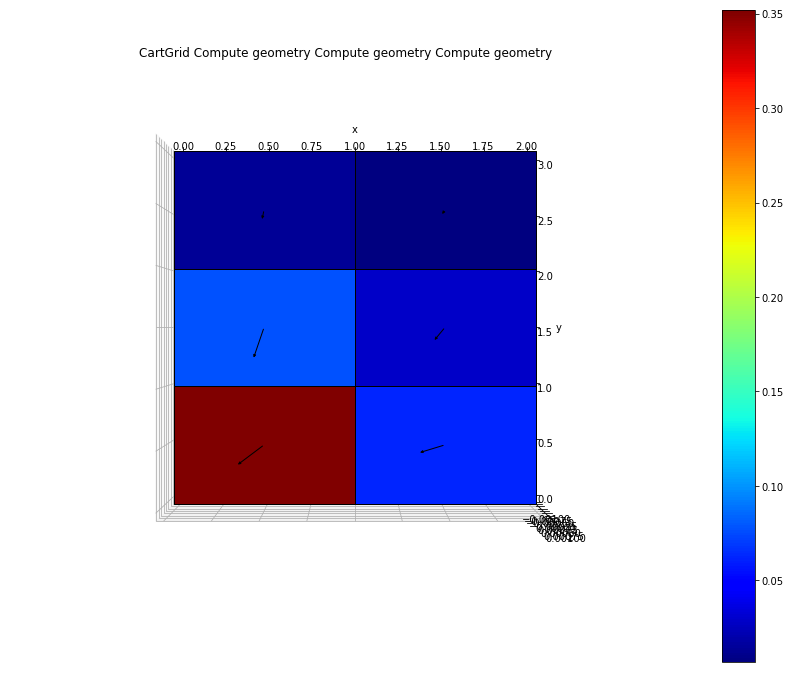

In [5]:
# We visualize the solution cell-wise using PorePy's plotting functionality,
# representing the pressure by colors and displacement by arrows. 
# To plot the displacement vectors, we first need to reshape them
# and add a zero value for the z direction. We also scale the values
# using the "vector_scale" argument for visualization purposes.
pressure = x[global_pressure_dof]
displacement = x[global_displacement_dof]
d = np.reshape(displacement, (2, g.num_cells), 'F')
d = np.vstack((d, np.zeros(g.num_cells)))
pp.plot_grid(g, pressure, d, figsize=(15, 12), vector_scale=10)